In [1]:
# Dicoding Course "Belajar Machine Learning untuk Pemula" Final Project: Image Classification

# Hanif Rachmadani on 14/07/2021

# note: Heavily-modified from "Latihan12-CNN Clean vs Messy Room"

In [2]:
# TF & Data-prepping Libraries Import

import zipfile,os,shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Dataset Download

!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rps.zip

--2021-07-14 08:42:58--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 307.92M  8.01MB/s    in 54s     

2021-07-14 08:43:53 (5.67 MB/s) - ‘/tmp/rps.zip’ saved [322873683/322873683]



In [4]:
# Dataset .zip Extraction

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/rockpaperscissors'
print(os.listdir(base_dir))

# Redundant Folder Removal

shutil.rmtree(os.path.join(base_dir, "rps-cv-images"))
print(os.listdir(base_dir))

['rps-cv-images', 'paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']
['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']


In [5]:
# ImageDataGenerator (Data Augmentation) Instantiation

image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.4)

# Training Data Generation                

train_generator = image_generator.flow_from_directory(
                  base_dir,
                  target_size=(100,150),
                  batch_size=32,
                  class_mode='categorical',
                  subset='training')

# Validation Data Generation

validation_generator = image_generator.flow_from_directory(
                  base_dir,
                  target_size=(100,150),
                  batch_size=32,
                  class_mode='categorical',
                  subset='validation')

# Classes' Labels Declaration

print(train_generator.class_indices)

class_label = ['Paper','Rock','Scissor']

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
{'paper': 0, 'rock': 1, 'scissors': 2}


In [6]:
# Model Design

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 150, 3)),  # Input Layer/1st Convolution Layer : 100x150 px Image split into RGB
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                             # 3 Convolution Layers
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),                                    # 2 Hidden Layer w/ 50% Dropouts on Each Layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')                                    # Output Layer
])

In [7]:
# Model Compilation

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
# Callback Declaration

class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):  
      print("Accuracy Target of >96% Reached, Stopping Training...")
      self.model.stop_training = True


In [9]:
# Model Training

history = model.fit(
      train_generator,
      batch_size=32,                            # 32 Data per Batch Loading
      steps_per_epoch=32,                       # 32 Batches Used per Epoch for Training
      epochs=30,                                # 30 Maximum Epoch (Arbitratry)
      validation_data=validation_generator,     
      validation_steps=25,                      # 25 Batches Used per Epoch for Validation
      callbacks=[modelCallback()],              # Callback
      verbose='auto')

Epoch 1/30
32/32 [==============================] - 12s 294ms/step - loss: 1.1050 - accuracy: 0.3360 - val_loss: 1.0958 - val_accuracy: 0.4400
Epoch 2/30
32/32 [==============================] - 9s 296ms/step - loss: 1.0789 - accuracy: 0.4165 - val_loss: 0.9967 - val_accuracy: 0.3775
Epoch 3/30
32/32 [==============================] - 9s 287ms/step - loss: 0.8596 - accuracy: 0.6268 - val_loss: 0.7107 - val_accuracy: 0.6112
Epoch 4/30
32/32 [==============================] - 9s 291ms/step - loss: 0.6576 - accuracy: 0.7535 - val_loss: 0.4408 - val_accuracy: 0.8775
Epoch 5/30
32/32 [==============================] - 9s 292ms/step - loss: 0.4711 - accuracy: 0.8260 - val_loss: 0.2422 - val_accuracy: 0.9212
Epoch 6/30
32/32 [==============================] - 9s 293ms/step - loss: 0.3898 - accuracy: 0.8642 - val_loss: 0.2272 - val_accuracy: 0.9312
Epoch 7/30
32/32 [==============================] - 9s 286ms/step - loss: 0.3874 - accuracy: 0.8702 - val_loss: 0.2010 - val_accuracy: 0.9300
Epoch

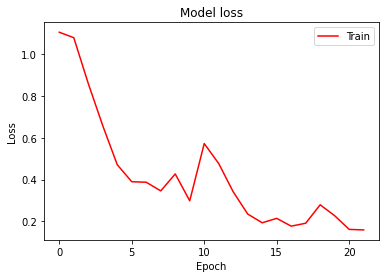

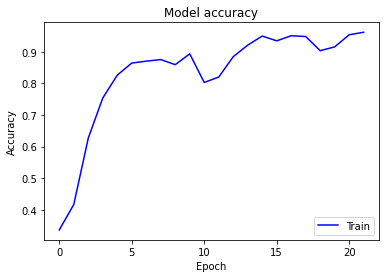

In [10]:
# Pyplot Import

import matplotlib.pyplot as plt

# Loss & Accuracy Graph

plt.plot(history.history['loss'], color="red")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'], color="blue")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

Saving B6dJfDThlXx80Uk6.png to B6dJfDThlXx80Uk6 (1).png
B6dJfDThlXx80Uk6.png
Paper


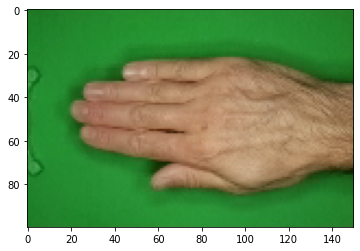

In [11]:
# Libraries Import

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

# Upload File(s)

uploaded = files.upload()

# Prediction for Each Files

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(100,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  print(class_label[np.argmax(classes)])